# Sandbox
### Olivia Cooper
### June 2022

In [59]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy.ndimage import gaussian_filter1d
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
plt.style.use('../cooper-paper.mplstyle')

In [ ]:
note = Table.read('../wmmc01/detnotes.txt',format='ascii')
mask = Table.read('../wmmc01/wmmc01_SlitList.txt',format='ascii')
note

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os

# for the optimized extraction shape

def gaussian(xaxis, mean, A, sig, offset): 
	'''
	Simple Gaussian function, to be used in the quick optimized extraction
	'''
	return A * np.exp(-np.power(xaxis-mean, 2.) / (2*np.power(sig, 2.))) + offset

def extract1d(obj,path,ycen,aper=7,width=4):
	'''
	Takes a mospy reduced MOS 2D image for a single object and manually extracts the 1D spectrum at 	a given y pixel using both boxcar and optimal extraction methods.
	
	INPUTS ---- obj:		str, name of the reduced 2D MOSFIRE file to be read in
		        path:		str, points to data directory
		        ycen:		int, row to extract spectrum on (pix)
				aper:		int, number of rows to extract the 1D spectrum over
				width:		int, pixel width for boxcar box
				
	RETURNS --- wave:		wavelength array
		        spec:		optimal extracted spectral array
                err:		error for optimal extracted spectral array
				specbox:	boxcar extracted spectral array
                errbox:		error for boxcar extracted spectral array
	'''

	# making sure the aperture is an odd number
	assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
		f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

	# reading in data
	print(f'\nReading in data for {obj}')
	header = fits.getheader(path + obj + '_eps.fits')
	signal = fits.getdata(path + obj + '_eps.fits')
	error = fits.getdata(path + obj + '_sig.fits')
	print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
			f'\t\t error spectrum {error.shape}')
	
	wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
	wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
	num_wavelength = header['NAXIS1'] # length of data array
	wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

	# defining optimized extraction gaussian
	pixscale = header['PSCALE'] # arcsec/pix
	fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	err = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)
    
	return wave, spec, err, specbox, errbox

In [3]:
### CHANGE THESE TO MATCH YOUR PATH AND OBJECT YOU WANT

obj_name = 'CAND_M44480' ### change me!
dir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_' ### change me! this path WILL be different on your computer

In [4]:
# manually extract 1D spec

ypix = 64 ### change me to the ypixel you are extracting the spectrum from
wav, opt, opterr, box, boxerr = extract1d(obj=obj_name,path=dir,ycen=ypix,aper=7,width=4) 


Reading in data for CAND_M44480
Dimensions: 	 signal spectrum (94, 1373)
		 error spectrum (94, 1373)


In [ ]:
# plot optimal

plt.plot(wav,opt,label='Optimal')
plt.fill_between(wav,opterr,-1*opterr,alpha=0.5,color='C0',label='Error')
plt.xlim(11040,11160) ### change me!
plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()

In [5]:
path=dir;obj=obj_name
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')

In [6]:
obj=obj_name;path=dir;ycen=ypix;aper=7;width=4

# making sure the aperture is an odd number
assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
    f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

# reading in data
print(f'\nReading in data for {obj}')
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')
print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
        f'\t\t error spectrum {error.shape}')

wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
num_wavelength = header['NAXIS1'] # length of data array
wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

# defining optimized extraction gaussian
pixscale = header['PSCALE'] # arcsec/pix
fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
gauss /= sum(gauss) # to make it sum to 1 to use as weights
gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
for i in range(aper):
    gauss_2D[i] = gauss[i]

# optimally-extracting 1D spectra
half = int(aper/2) # to make the cut out of the 2D image
spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
err = np.nansum(signal[35-half:35+half+1].copy()*gauss_2D,axis=0)

# boxcar extract 1D spec
row1, row2 = ycen-width, ycen+width # define the target aperture range
specbox = np.sum(signal[row1:row2, :], axis=0)
errbox = np.sum(error[row1:row2, :], axis=0)


Reading in data for CAND_M44480
Dimensions: 	 signal spectrum (94, 1373)
		 error spectrum (94, 1373)


In [7]:
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
sigma_clip = SigmaClip(sigma=3.0)
bkgrms = StdBackgroundRMS(sigma_clip)

In [21]:
bkgrms_value = bkgrms.calc_background_rms(signal,axis=0)
bkgrms_sky = bkgrms.calc_background_rms(error,axis=0)

/Users/oc4858/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


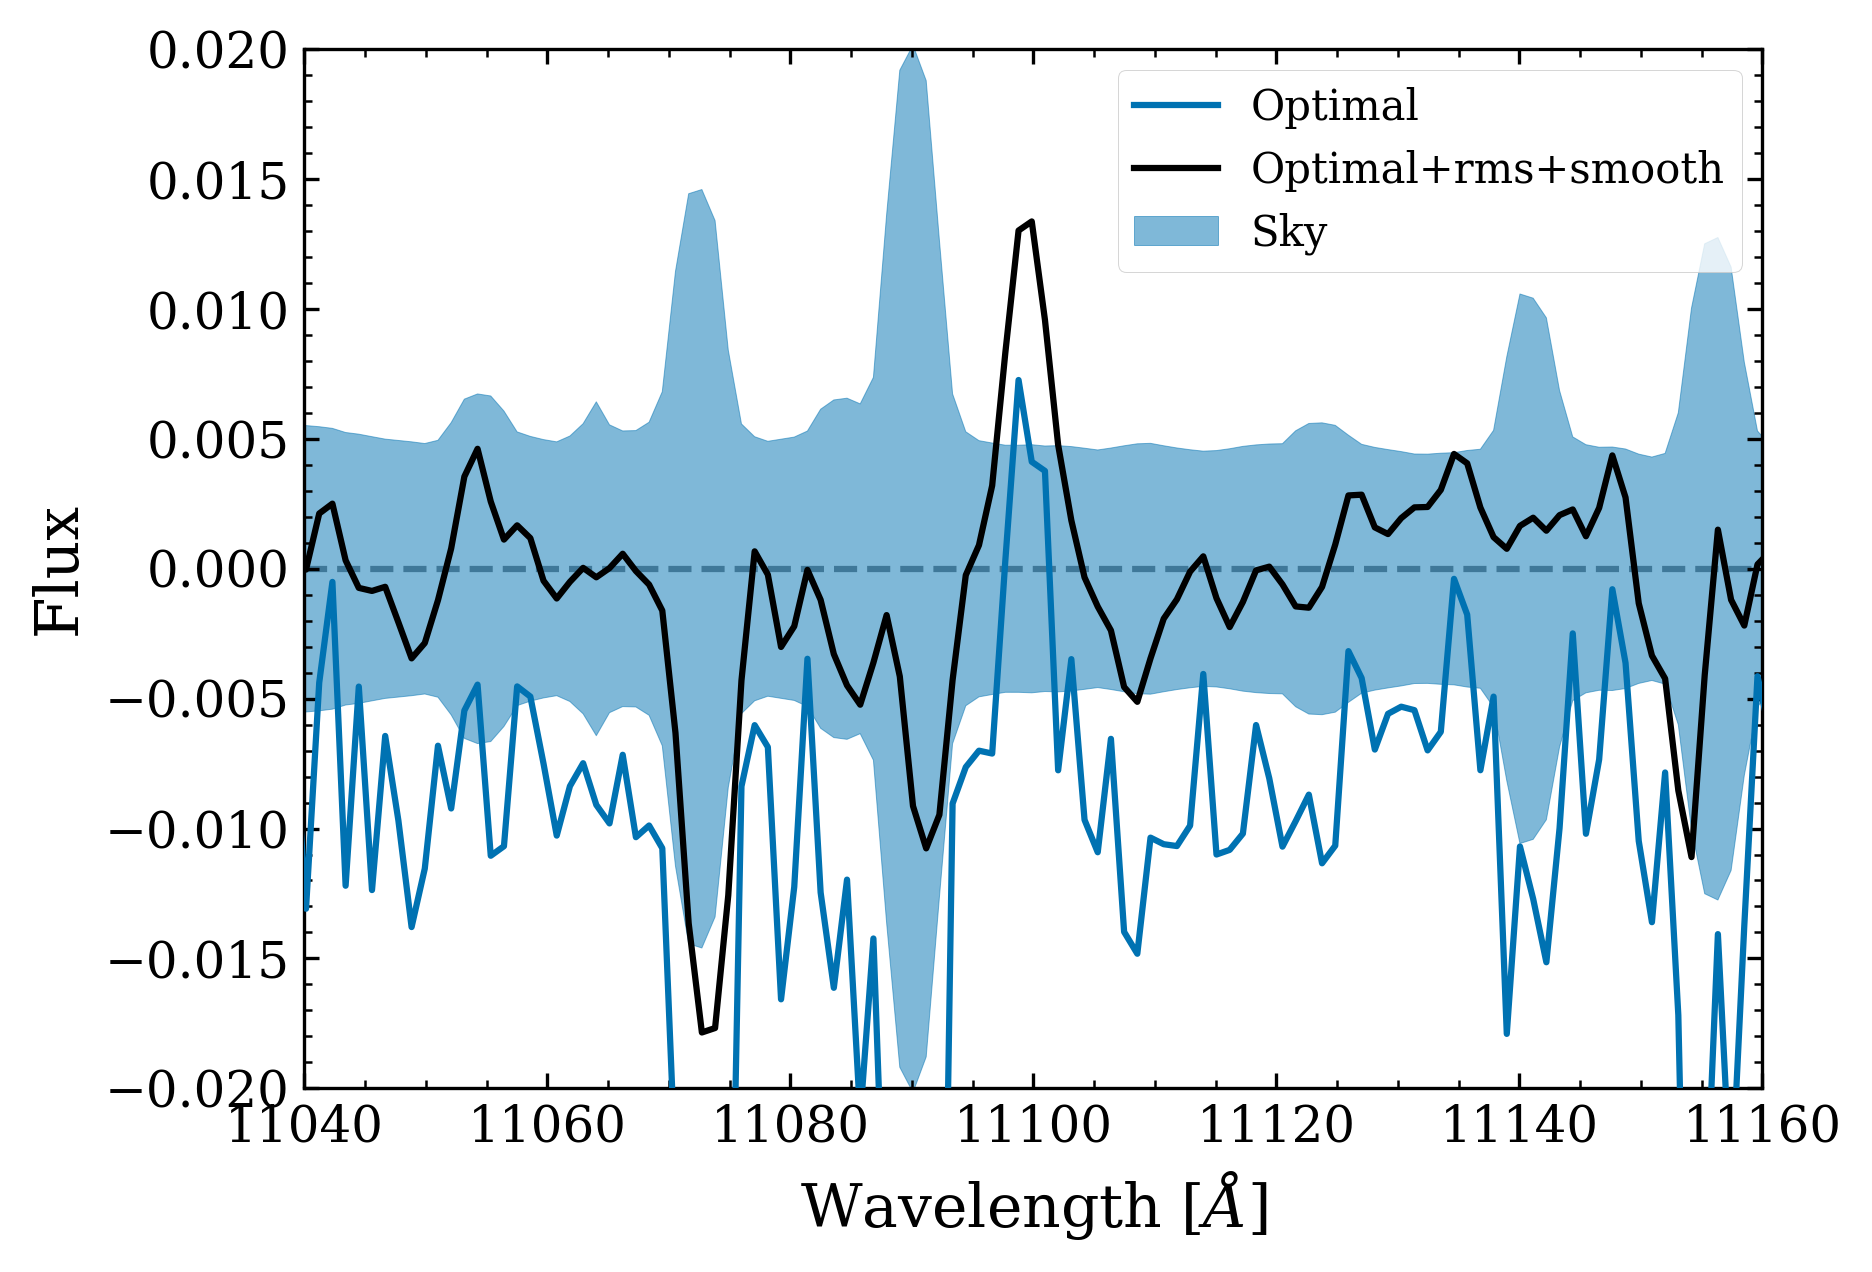

In [58]:
# plot optimal

plt.plot(wav,opt,label='Optimal',zorder=20)
plt.plot(wav,gaussian_filter1d(opt+bkgrms_value,sigma=1),'k',label='Optimal+rms+smooth')

plt.fill_between(wav,np.nanmedian(error,axis=0),-1*np.nanmedian(error,axis=0),alpha=0.5,color='C0',label='Sky')
plt.axhline(0,color='gray',zorder=0,ls='--')
plt.xlim(11040,11160) ### change me!
plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()
#plt.savefig('cand_m44480_rms_test.png')

In [10]:
np.median(opt),np.median(opt+bkgrms_value)

(-0.008327997009806798, 0.00020693317079385157)

In [81]:
sigma_clip = SigmaClip(sigma=3.0)
bkgrms = StdBackgroundRMS(sigma_clip)
bkgrms_value = bkgrms.calc_background_rms(signal,axis=0)
bkgrms_value

array([0.00524341, 0.00590753, 0.00641911, ..., 0.        , 0.        ,
       0.        ])

In [107]:
sky_idx = np.where(np.logical_or((bkgrms_value > np.mean(bkgrms_value)) == True, bkgrms_value == 0))[0]

In [117]:
# block out sky lines 2D
#sky_idx = np.where(bkgrms_value > np.mean(bkgrms_value))[0]
bkg = bkgrms_value.copy()
bkg[sky_idx] = np.nan
z = np.polyfit(wav[5:-5],np.isfinite(bkg)[5:-5],deg=2)
fit = np.poly1d(z)
z

array([-5.84361703e-08,  1.16455280e-03, -5.07713486e+00])

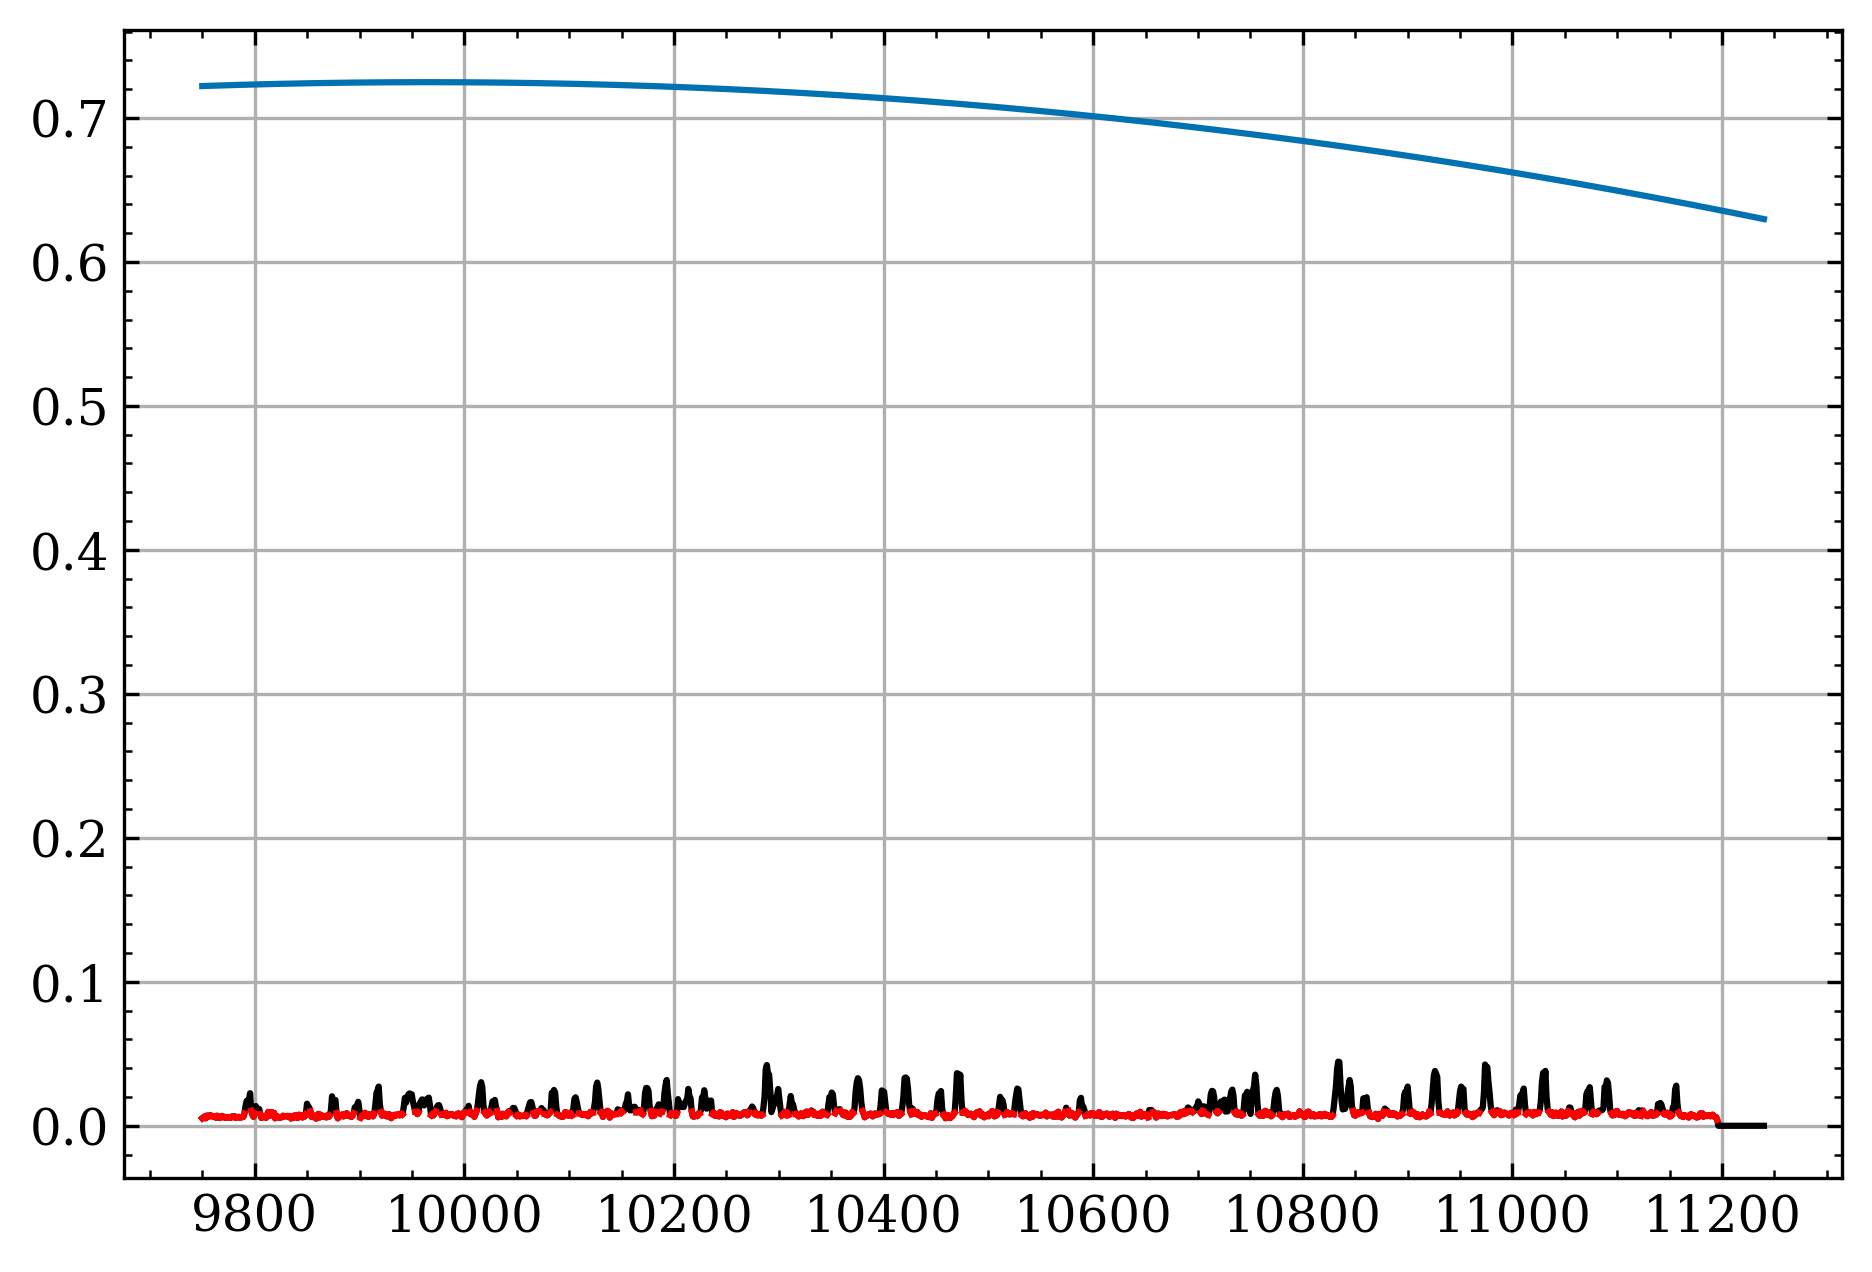

In [118]:
plt.plot(wav,bkgrms_value,'k',label='rolling rms at eps')
plt.plot(wav,bkg,'r',label='rolling rms at eps')
plt.plot(wav, fit(wav))

/Users/oc4858/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


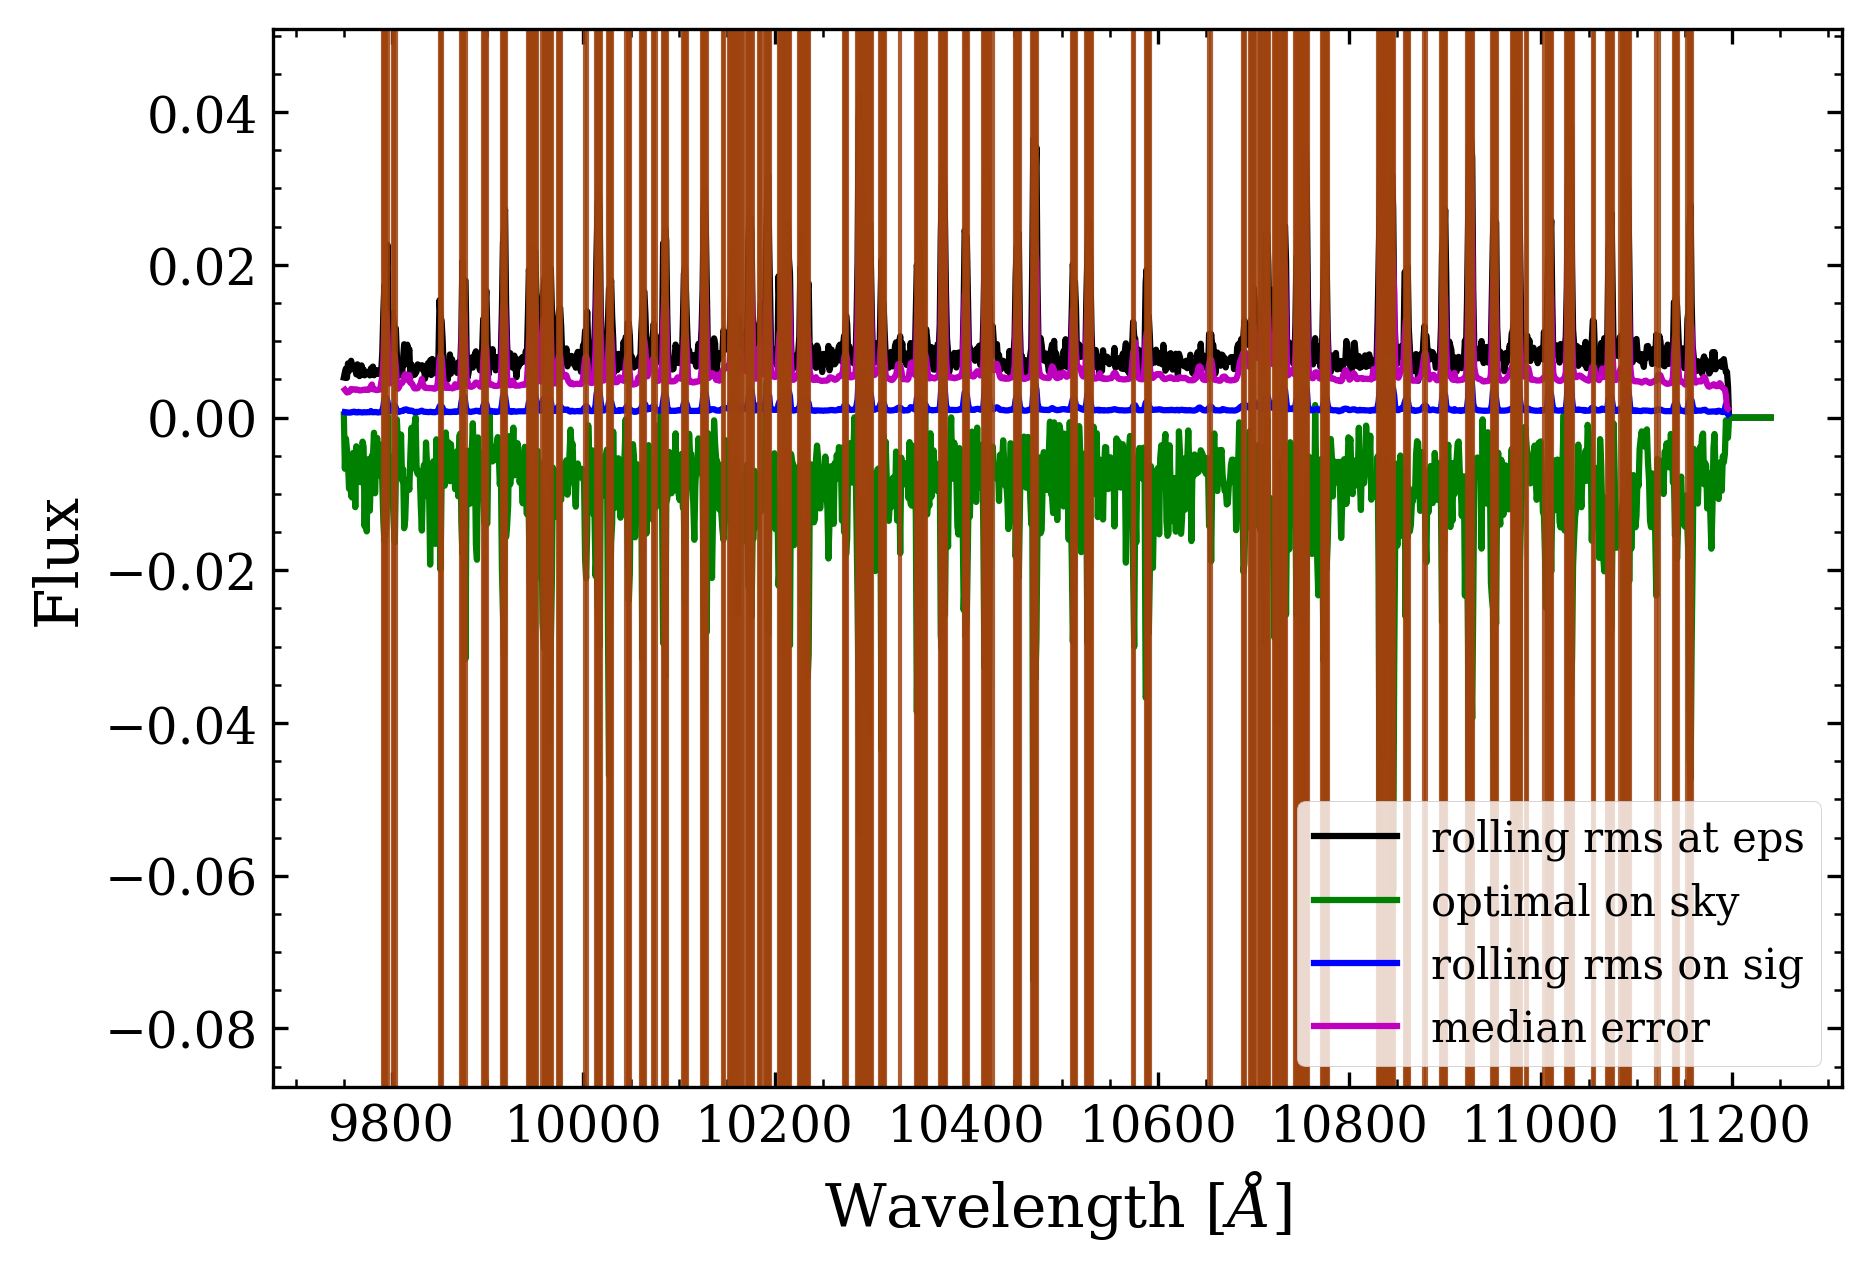

In [78]:
plt.plot(wav,bkgrms_value,'k',label='rolling rms at eps')
plt.plot(wav,err,'g',label='optimal on sky')
plt.plot(wav,bkgrms_sky,'b',label='rolling rms on sig')
plt.plot(wav,np.nanmedian(error,axis=0),'m',label='median error')

for i in sky_idx2:
    plt.axvline(wav[i],c='#9E420E',lw=1,alpha=0.85)
    
#plt.xlim(11040,11160) ### change me!
#plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()

In [46]:
np.nanmedian(error,axis=0)

/Users/oc4858/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


array([       nan, 0.00363186, 0.00345931, ...,        nan,        nan,
              nan], dtype=float32)

In [28]:
(11099.5/1216)-1

8.127878289473685

In [29]:
def closest(lst, val):
    lst = np.asarray(lst) 
    idx = (np.abs(lst - val)).argmin() 
    return idx,lst[idx]

In [30]:
idx, wvl = closest(wav,11099.5)

In [31]:
n = opterr[idx]

In [32]:
s = opt[idx]+bkgrms_value[idx]

In [33]:
s/n

3.055524872029658

In [37]:
from astroquery.ipac.irsa import Irsa

In [39]:
Irsa.list_catalogs()

{'allwise_p3as_psd': 'AllWISE Source Catalog',
 'allwise_p3as_mep': 'AllWISE Multiepoch Photometry Table',
 'allwise_p3as_psr': 'AllWISE Reject Table',
 'allwise_p3as_cdd': 'AllWISE Atlas Metadata Table',
 'allwise_p3am_xrf': 'AllWISE Frame Cross-Reference Table',
 'allwise_p3al_lod': 'AllWISE Atlas Inventory Table',
 'allwise_p3am_cdd': 'AllWISE Atlas Image Inventory Table',
 'allwise_mfpos': 'AllWISE Refined Pointing Information for the Single-exposure Images',
 'neowiser_p1bs_psd': 'NEOWISE-R Single Exposure (L1b) Source Table',
 'neowiser_p1ba_mch': 'NEOWISE-R Known Solar System Object Possible Association List ( Caution )',
 'neowiser_p1bs_frm': 'NEOWISE-R Single Exposure (L1b) Frame Metadata Table',
 'neowiser_p1bl_lod': 'NEOWISE-R Single Exposure (L1b) Scan Inventory Table',
 'neowiser_p1bm_frm': 'NEOWISE-R Single Exposure (L1b) Image Inventory Table',
 'allsky_4band_p3as_psd': 'WISE All-Sky Source Catalog',
 'allsky_4band_p1bs_psd': 'WISE All-Sky Single Exposure (L1b) Source Ta

In [ ]:
# the basics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import read_mospy_files as rmp ## script I made to read in mospy files
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.cosmology import Planck15 as cosmo
import extract_1d_spec as ex
plt.style.use('../../cooper-presentation.mplstyle')
# select object
notes = Table.read('../wmmc03/cooper_notes_wmmc03.csv',format='csv')
idx = 7
obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')
# open 1D and 2D spectrum for an object
dir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_'
hdu2 = fits.open(dir+obj_name+'_eps.fits') # 2D spectrum
pix_obj, wav_obj, _ = rmp.make_1d_array(ext=0,hdu=hdu2) # object spectrum
image = hdu2[0].data
pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale
# manually extract 1D spec
ypix = 64 ### change me!
wav, opt, opterr, box, boxerr = ex.extract1d(obj=obj_name,path=dir,ycen=ypix,aper=7,width=4)
obj_pos = 64 ### change me!
# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)
### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)
# 1D spec
ax1.plot(pix_obj,opt,c='chocolate',label='optimal')
ax1.fill_between(pix_obj,opterr,-1*opterr,color='gray', label='error')
ax1.set_ylabel(r'Flux')
#ax1.legend()
# 2D spec
lower=-1; upper=2
sample = sigma_clip(hdu2[0].data)
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)
# block out sky lines 2D
ipk = find_peaks(opterr, height=np.mean(opterr))[0]
for i in ipk:
    ax2.axvline(pix_obj[i],c='#9E420E',lw=15,alpha=0.85)
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, pix_obj, wav_obj)
def inverse(x):
    return np.interp(x, wav_obj, pix_obj)
secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')
# mark measured line at pixel guess based on lambda guess
pguess = pix_obj[rmp.closest(wav_obj,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')
# mark obj position on slit and nods
ax2.axhline(obj_pos,xmin=0,xmax=0.1,lw=2,c='chocolate')
ax2.axhline(obj_pos,xmin=0.9,xmax=1,lw=2,c='chocolate')
ax2.axhline(obj_pos+nodamp,xmin=0,xmax=0.1,lw=2,c='k')
ax2.axhline(obj_pos+nodamp,xmin=0.9,xmax=1,lw=2,c='k')
ax2.axhline(obj_pos-nodamp,xmin=0,xmax=0.1,lw=2,c='k')
ax2.axhline(obj_pos-nodamp,xmin=0.9,xmax=1,lw=2,c='k')
# limits
ax1.set_xlim(pguess-60,pguess+60)
ax1.set_ylim(-0.02,0.012)
ax2.set_xlim(pguess-60,pguess+60)
ax2.set_ylim(35,90)
ax1.annotate('z = '+str(zguess),xy=(pguess-55,0.007),fontsize=10,c='chocolate')
fig.savefig('plots/wmmc03/'+obj_name+'_manual_optimal_1D_2D_lines.png',dpi=500)